BCLIMATE
RCS
RSDA
H-CEL
RMIB-UGENT


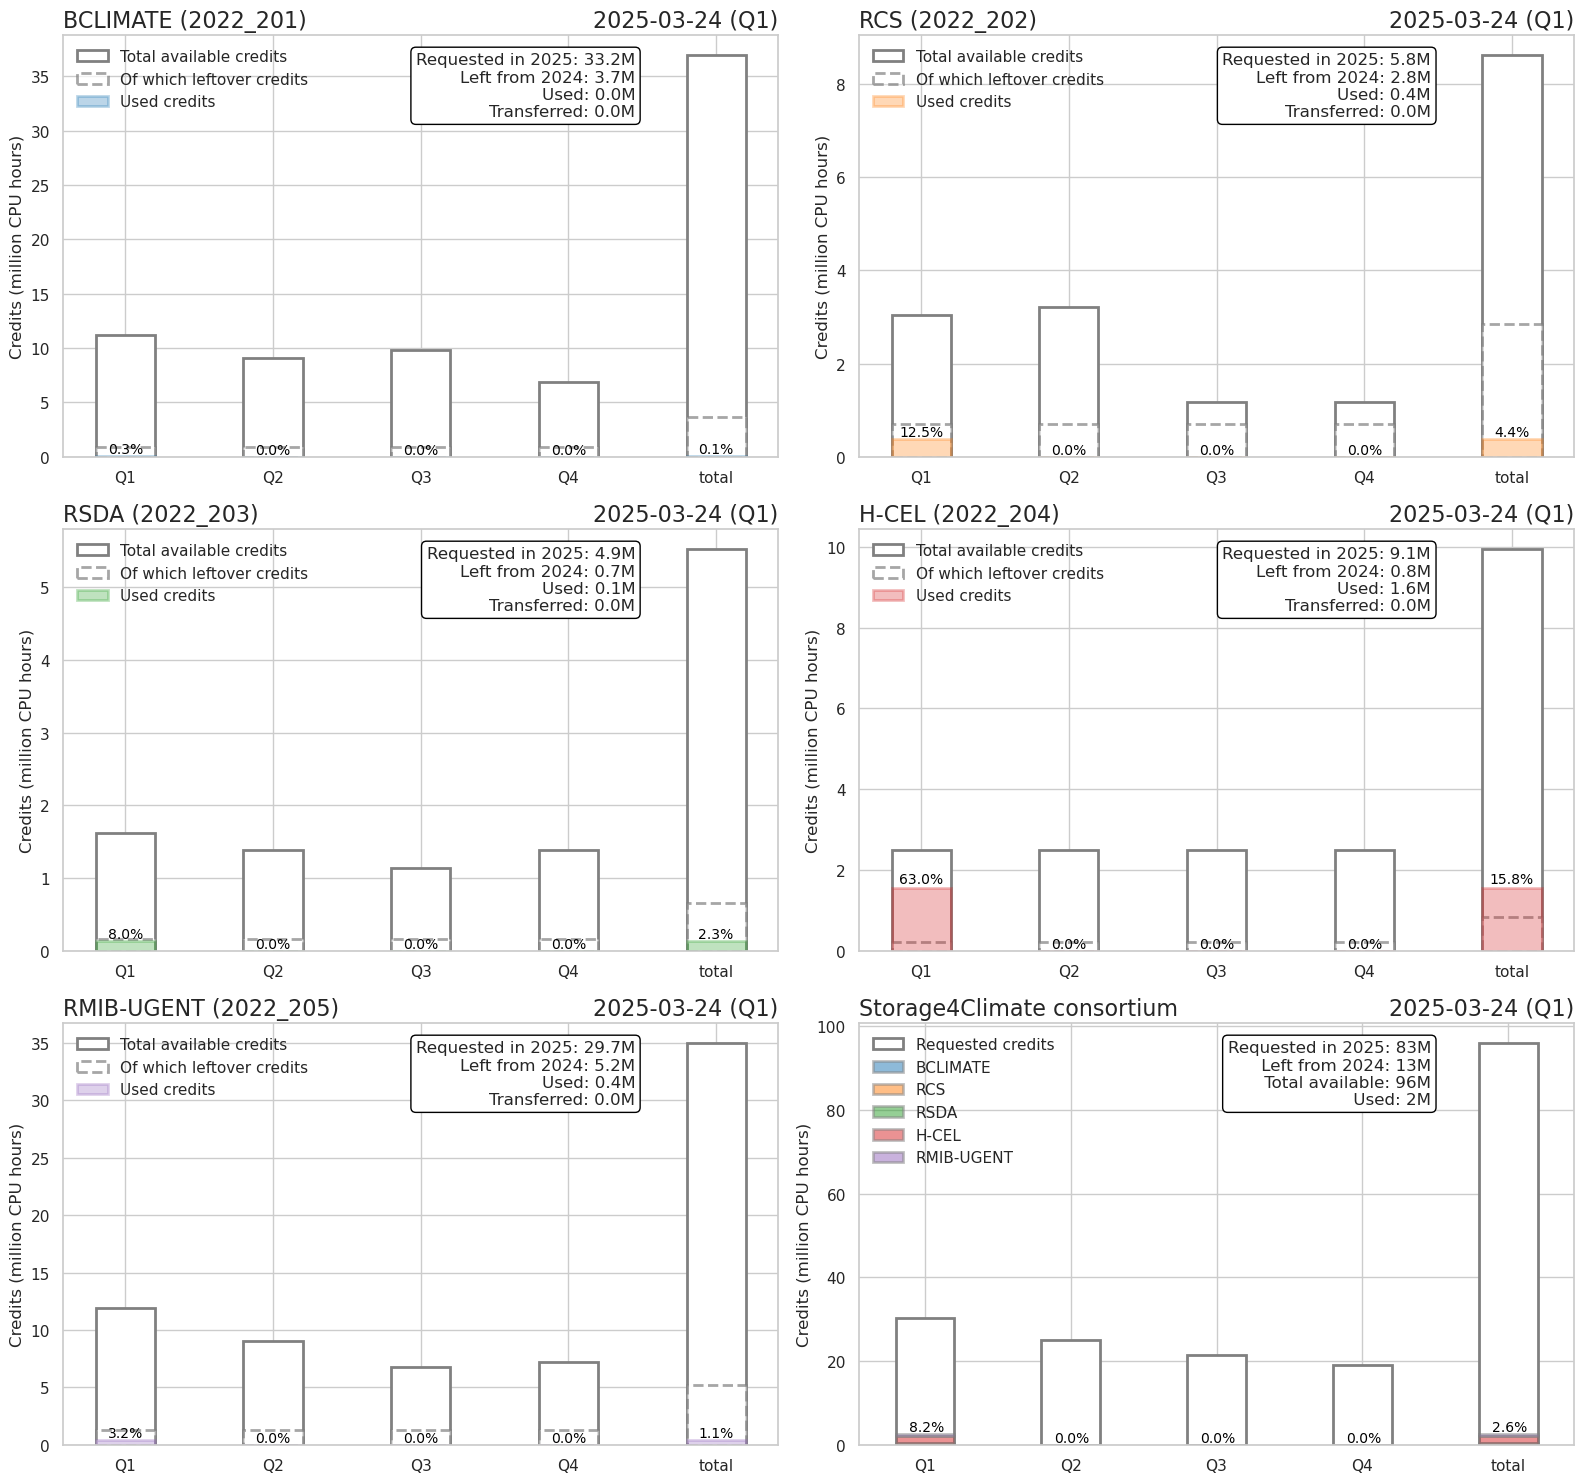

FileNotFoundError: [Errno 2] No such file or directory: '/output/monitoring.png'

<Figure size 640x480 with 0 Axes>

In [37]:
import pandas as pd
pd.options.mode.copy_on_write = True
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import numpy as np
import os


#########################
#       Settings        #
#########################


year = '2025'
current_quarter = 'Q1'

d_quarters = {'Q1': pd.date_range(start=pd.to_datetime("2025-02-08"),end=pd.to_datetime("2025-05-08")), 
              'Q2': pd.date_range(start=pd.to_datetime("2025-05-08"),end=pd.to_datetime("2025-08-08")), 
              'Q3': pd.date_range(start=pd.to_datetime("2025-08-08"),end=pd.to_datetime("2025-11-08")), 
              'Q4': pd.date_range(start=pd.to_datetime("2025-11-08"),end=pd.to_datetime("2026-02-08")), 
              'total': pd.date_range(start=pd.to_datetime("2025-02-08"),end=pd.to_datetime("2026-02-08")) }

time_range_previous_cycle = pd.date_range(start=pd.to_datetime("2024-02-08"),end=pd.to_datetime("2025-02-08"))

d_projects = {'BCLIMATE'  :  '2022_201', 
              'RCS'       :  '2022_202', 
              'RSDA'      :  '2022_203',
              'H-CEL'     :  '2022_204',
              'RMIB-UGENT':  '2022_205'}



# Create bar plots
#Set the style of the plots 
sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(3,2,figsize=(16, 15))
axes= axes.flatten()
colors = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple']
date = pd.to_datetime('today').strftime('%Y%m%d')


#########################
#        Inputs         #
#########################

#Get the git directory
path_monitoring = "" #f"./check_resource_usage/VSC_monitoring/"
# load requested resources in S4C proposal

df_requested_2024 = pd.read_csv(f"{path_monitoring}requested_resources_2024.csv", delimiter=";",index_col=0)
df_transferred_2024 = pd.read_csv(f"{path_monitoring}transferred_resources_2024.csv", delimiter=";",index_col=0)

df_used_2024 = pd.read_csv(f"{path_monitoring}used_resources_2024.csv", delimiter=";",index_col=0)

# the final amount of credits available is the sum of the requested credits in the proposal and the transferred credits from the previous year, minus the use of the previous year. 

ds_left_from_2024 = df_requested_2024['total']+ df_transferred_2024['total']  - df_used_2024['total']

# redistribute what is left of 2024 evenly over quarters
df_left_from_2024 = ds_left_from_2024.to_frame(name='total')

for quarter in ['Q1', 'Q2', 'Q3', 'Q4']:
    df_left_from_2024[quarter] = df_left_from_2024['total'].div(4)

df_left_from_2024.reindex(columns=['Q1', 'Q2', 'Q3', 'Q4','total'])

# load requested resources in S4C proposal in 2025
df_requested_year = pd.read_csv(f"{path_monitoring}requested_resources_{year}.csv", delimiter=";",index_col=0)
df_transferred_year = pd.read_csv(f"{path_monitoring}transferred_resources_{year}.csv", delimiter=";",index_col=0)


df_requested = df_left_from_2024 + df_requested_year + df_transferred_year


# select one project group

for i, group in enumerate(d_projects.keys()): 
    print(group)
    project = d_projects[group]

    quarter_credits = df_requested.loc[group]


    # read the input files
    path = rf'{path_monitoring}input'
    all_files = glob.glob(f'{path}/*{project}.csv')

    df = pd.read_csv(all_files[0], header=1)

    #########################
    #     Pre-processing    #
    #########################


    #Get the index of the row containing project logs in resource column
    index_logs = df[df['Resource'] == 'Project Logs'].index[0]
    df_overview = df[:index_logs]
    df_credits = df_overview[df_overview['Resource'] == 'credits']
    df_credits['Total_used'] = df_credits['Current used by user'].str.replace(' Hours', '').astype(float)
    df_credits['Cumulative_used_by_user'] = df_credits['Total used by user'].str.replace(' Hours', '').astype(float)
    df_credits['Cumulative_total_used'] = df_credits['Total used'].str.replace(' Hours', '').astype(float)
    df_credits['Date'] =  pd.to_datetime(pd.to_datetime(df_credits['Date'], format='%d/%m/%Y - %H:%M').dt.date)
    df_credits = df_credits.sort_values(by='Date')

    Total_credits = quarter_credits['total']

    #Make a dictionary with the remaining credits per quarter by subtracting the total used from the total credits per quarter until there are no credits left
    used_credits = quarter_credits.copy().loc[['Q1','Q2','Q3','Q4']]

    
    used_credits_previouscycle = (df_credits[df_credits['Date'].isin(time_range_previous_cycle)]['Total_used']).sum()


    for key in d_quarters.keys():

        df_credits_quarter = df_credits[df_credits['Date'].isin(d_quarters[key])]
        used_credits[key] = (df_credits_quarter['Total_used']).sum()
        


    # save loaded credits for stacked bar plot
    if i==0: 
        df_requested_credits = quarter_credits.to_frame()
        df_used_credits = used_credits.to_frame()
    else: 
    
        df_requested_credits = df_requested_credits.merge(quarter_credits.to_frame(), left_index=True, right_index=True)
        df_used_credits = df_used_credits.merge(used_credits.to_frame(), left_index=True, right_index=True)

    #########################
    #     Plotting          #
    #########################

    ax = axes[i]
    # Plot remaining_credits and quarter_credits

    ax.bar(quarter_credits.index, quarter_credits.values*1e-6, label='Total available credits', color='white',  edgecolor='gray', linewidth=2, width=0.4, align='center')
    ax.bar(df_left_from_2024.loc[group].index, df_left_from_2024.loc[group].values*1e-6, label='Of which leftover credits', color='white',edgecolor='gray', linewidth=2,linestyle='dashed', alpha=0.7, width=0.4, align='center')

    ax.bar(used_credits.index, used_credits.values*1e-6, label='Used credits', color=colors[i],edgecolor=colors[i], linewidth=2, alpha=0.3, width=0.4, align='center')

    # Add percentage text on top of each bar (used/quarter credits)
    for idx in range(len(quarter_credits) ):  # Exclude 'total' row for now
        quarter_value = quarter_credits.iloc[idx]
        used_value = used_credits.iloc[idx]
        if quarter_value > 0:  # Avoid division by zero
            percentage_used = (used_value / quarter_value) * 100
            ax.text(idx, (used_value * 1e-6) + (used_value * 1e-6)*0.02, f'{percentage_used:.1f}%', ha='center', va='bottom', fontsize=10, color='black')


    # Add the total number of quarter and used credits in a box
    total_requested_credits = df_requested_year.loc[group]['total']
    total_used_credits = used_credits['total']
    total_transferred_credits = df_transferred_year.loc[group]['total']
    total_left_credits = df_left_from_2024.loc[group]['total']

    text_str = f'Requested in {year}: {total_requested_credits * 1e-6:.1f}M\nLeft from 2024: {total_left_credits * 1e-6:.1f}M\nUsed: {total_used_credits * 1e-6:.1f}M\nTransferred: {total_transferred_credits * 1e-6:.1f}M'

    # Add text with a box around it
    ax.text(0.8, 0.96, text_str, transform=ax.transAxes, ha='right', va='top', fontsize=12,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    # Customize the plot
    ax.set_ylabel('Credits (million CPU hours)')
    ax.set_title(f'{pd.to_datetime(date).date()} ({current_quarter})', loc='right', size=16)

    ax.set_title(f'{group} ({project})', loc='left', size=16)
    ax.legend( frameon=False, loc='upper left')

## stacked figure

ax = axes[-1]

df_used_credits.loc['total'] = df_used_credits.loc[['Q1','Q2','Q3','Q4']].sum()


(df_requested_credits*1e-6).sum(axis=1).plot.bar(ax=ax, label='Requested credits', color='white',  edgecolor='gray', linewidth=2, width=0.4, align='center')

(df_used_credits*1e-6).plot.bar(ax=ax, stacked=True, label='Used credits', color=colors,linewidth=2,  edgecolor='gray', alpha=0.5, width=0.4, align='center')


for idx in range(len(df_requested_credits) ):  # Exclude 'total' row for now
    quarter_value = (df_requested_credits.sum(axis=1)*1e-6).iloc[idx]
    used_value = (df_used_credits*1e-6).sum(axis=1).iloc[idx]
    if quarter_value > 0:  # Avoid division by zero
        percentage_used = (used_value / quarter_value) * 100
        ax.text(idx+0.01, (used_value ) + (used_value )*0.02, f'{percentage_used:.1f}%', ha='center', va='bottom', fontsize=10, color='black')


# Add the total number of quarter and used credits in a box
total_quarter_credits = (df_requested_year.drop(columns=['total']).transpose()).sum().sum()#(df_requested_credits.loc[['Q1','Q2','Q3','Q4']]).sum(axis=1).sum()
total_requested_left_credits = (df_requested_credits.loc[['Q1','Q2','Q3','Q4']]).sum(axis=1).sum()

total_used_credits = (df_used_credits.loc[['Q1','Q2','Q3','Q4']]).sum().sum()
total_left_from_2024 = (df_left_from_2024.drop(columns=['total']).transpose()).sum().sum()


text_str = f'Requested in {year}: {total_quarter_credits * 1e-6:.0f}M\n Left from 2024: {total_left_from_2024 * 1e-6:.0f}M\n Total available: {total_requested_left_credits * 1e-6:.0f}M\n Used: {total_used_credits * 1e-6:.0f}M'

# Add text with a box around it
ax.text(0.8, 0.96, text_str, transform=ax.transAxes, ha='right', va='top', fontsize=12,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Customize the plot
ax.set_ylabel('Credits (million CPU hours)')
ax.set_title(f'{pd.to_datetime(date).date()} ({current_quarter})', loc='right', size=16)
ax.set_xticklabels(list(df_requested_credits.index), rotation=0)
ax.set_title(f'Storage4Climate consortium', loc='left', size=16)
ax.legend( frameon=False, loc='upper left')



# Show plot
plt.tight_layout()
plt.show()


# save figure and table
plt.savefig(f'{path_monitoring}/output/monitoring.png')
df_used_credits.to_csv(f'{path_monitoring}/output/used_resources.csv')

#Move the csv file to the output archive folder

shutil.move(all_files[0], f'{path_monitoring}/archive/')
shutil.copy(f'{path_monitoring}/output/monitoring.png', f'{path_monitoring}/archive/{current_quarter}_{date}_monitoring.png')
shutil.copy(f'{path_monitoring}/output/used_resources.csv', f'{path_monitoring}/archive/{current_quarter}_{date}_used_resources.csv')




### Determine credits used in previous cycle

In [3]:

# determine used credits in previous cycle (2024)

for i, group in enumerate(d_projects.keys()): 
    print(group)
    project = d_projects[group]

    # read the input files
    path = rf'{path_monitoring}input'
    all_files = glob.glob(f'{path}/*{project}.csv')

    df = pd.read_csv(all_files[0], header=1)

    #Get the index of the row containing project logs in resource column
    index_logs = df[df['Resource'] == 'Project Logs'].index[0]
    df_overview = df[:index_logs]
    df_credits = df_overview[df_overview['Resource'] == 'credits']
    df_credits['Total_used'] = df_credits['Current used by user'].str.replace(' Hours', '').astype(float)
    df_credits['Cumulative_used_by_user'] = df_credits['Total used by user'].str.replace(' Hours', '').astype(float)
    df_credits['Cumulative_total_used'] = df_credits['Total used'].str.replace(' Hours', '').astype(float)
    df_credits['Date'] =  pd.to_datetime(pd.to_datetime(df_credits['Date'], format='%d/%m/%Y - %H:%M').dt.date)
    df_credits = df_credits.sort_values(by='Date')

    used_credits_previouscycle = (df_credits[df_credits['Date'].isin(time_range_previous_cycle)]['Total_used']).sum()
    df_used_2024.loc[group,"total"] = int(used_credits_previouscycle)



BCLIMATE
RCS
RSDA
H-CEL
RMIB-UGENT
